In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import glob
# from shutil import copyfile
# import os

# for f in glob.glob('./data/translations/*/*/translations.csv'):
#     target_path = f.replace('data', 'cache').rstrip('translations.csv')
#     os.makedirs(os.path.dirname(target_path), exist_ok=True)
#     copyfile(f, f.replace('data', 'cache'))

In [3]:
# import glob
# from shutil import copyfile
# import os

# for f in glob.glob('./cache/translations/*/*/translations.csv'):
#     target_path = f.replace('cache', 'data').rstrip('translations.csv')
#     os.makedirs(os.path.dirname(target_path), exist_ok=True)
#     copyfile(f, f.replace('cache', 'data'))

In [4]:
import statistics
import math
import matplotlib.pyplot as plt
from unidecode import unidecode
from collections import Counter
import numpy as np


def binary_ci(success, total, alpha=0.95):
    """
    Using Agresti-Coull interval
    
    Return mean and confidence interval (lower and upper bound)
    """
    z = statistics.NormalDist().inv_cdf((1 + alpha) / 2)
    total = total + z**2
    loc = (success + (z**2) / 2) / total
    diameter = z * math.sqrt(loc * (1 - loc) / total)
    return loc, loc - diameter, loc + diameter 


def set_size(w,h, ax=None):
    """
    Used to size the figures with subplots
    
    https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
    """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


In [64]:
sentences = []
stereotypes = []

for line in open('./data/samples.txt'):
    words = line.split()
    sentences.append(' '.join(words[:-1]))
    stereotypes.append(int(words[-1]))

stereo_names = """
Emotional
Gentle
Empathetic
Neat
Social
Weak
Beautiful
Tough
Self-confident
Professional
Rational
Providers
Leaders
Childish
Sexual
Strong
""".strip().split('\n')
stereo_names = [
    f'{name} #{i+1}'
    for i, name in enumerate(stereo_names)
]

In [6]:
"""
Retrieving unsaved translations from logs
"""

# import os
# google_translate = GoogleTranslate(
#     data_path='./cache/translations/google_translate',
#     target_language=target_language,
#     enable_api=False
# ).load()

# for i in range(1, 201):
#     fdir = '/labs/cache/translations/google_translate/cs/logs'
#     fin, fout = os.path.join(fdir, f'{i}.from'), os.path.join(fdir, f'{i}.to')
#     from_, to_ = open(fin).read(), open(fout).read()
#     if from_ not in google_translate.dataframe.index:
#         google_translate.dataframe.loc[from_] = to_

# google_translate.save()

'\nRetrieving unsaved translations from logs\n'

In [7]:
from translators.google_translate import GoogleTranslate
from translators.amazon_translate import AmazonTranslate
from translators.deepl import DeepL
from translators.nllb import NLLB

supported_languages = {
    DeepL: ['cs', 'pl', 'ru', 'sl', 'sk', 'uk'],
    AmazonTranslate: ['cs', 'pl', 'ru', 'sl', 'sk', 'uk', 'sr', 'hr'],
    GoogleTranslate: ['cs', 'pl', 'ru', 'sl', 'sk', 'uk', 'sr', 'hr', 'be'],
    NLLB: ['cs', 'pl', 'ru', 'sl', 'sk', 'uk', 'sr', 'hr', 'be'],
}

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# from unidecode import unidecode
# from parser import Parser

# # import logging
# # logging.basicConfig()
# # logging.getLogger('deepl').setLevel(logging.WARNING)

# for translator_class in translator_classes:
#     for target_language in supported_languages[translator_class]:
#         translator = translator_class(
#             # dir_path='./cache/translations/nllb_3b',
#             target_language=target_language,
#             # enable_api=True,
#             # server_url='https://api.deepl.com/',
#         ).load()
#         parser = Parser(language=target_language).load_model()
#         for x in range(len(sentences)//100 + 1):   
#         # for x in range(1):   
#             translations = translator.translate(sentences[x*100: x*100 + 100], save=True)
#             parser.parse(list(translations.values()))
# google_translate = GoogleTranslate(
#     data_path='./cache/translations/google_translate',
#     target_language=target_language,
#     enable_api=False
# ).load()


In [9]:
from functools import lru_cache

from parser import Parser

from gender_heuristics.heuristics import run_heuristics_wrapper
from gender_heuristics.l_be import be_heuristics
from gender_heuristics.l_bg import bg_heuristics
from gender_heuristics.l_cs import cs_heuristics
from gender_heuristics.l_hr import hr_heuristics
from gender_heuristics.l_pl import pl_heuristics
from gender_heuristics.l_sk import sk_heuristics
from gender_heuristics.l_sl import sl_heuristics
from gender_heuristics.l_sr import sr_heuristics
from gender_heuristics.l_sr_latn import sr_latn_heuristics
from gender_heuristics.l_ru import ru_heuristics
from gender_heuristics.l_uk import uk_heuristics

heuristics_map = {
    'bg': bg_heuristics,
    'be': be_heuristics,
    'cs': cs_heuristics,
    'hr': hr_heuristics,
    'pl': pl_heuristics,
    'sk': sk_heuristics,
    'sl': sl_heuristics,
    'sr': sr_heuristics,
    'ru': ru_heuristics,
    'uk': uk_heuristics,
}

@lru_cache
def predictions(translator_class, language, lazy):

    translator = translator_class(target_language=language).load()
    parser = Parser(language=language)

    heuristics = heuristics_map[language]

    if translator_class == AmazonTranslate and language == 'sr':
        heuristics = sr_latn_heuristics

    h = run_heuristics_wrapper(heuristics, lazy)
    buf = []
    for sentence, stereotype in zip(sentences, stereotypes):
        try:
            translation = translator.dataframe.loc[sentence]['to']
        except KeyError:
            continue
        tokens = parser.dict[translation]['sentences'][0]['tokens']
        buf.append(h(translation, tokens))

    return buf
 


INFO:trankit.adapter_transformers.file_utils:PyTorch version 2.0.1+cu117 available.


In [10]:
translator_classes = AmazonTranslate, DeepL, GoogleTranslate, NLLB
for translator_class in translator_classes:
    print(translator_class.__name__)
    for lang in ['be', 'hr', 'cs', 'pl', 'ru', 'sl', 'sk', 'sr', 'uk']:
        print(lang, sum(map(bool, predictions(translator_class, lang, lazy=True))))
    print()

INFO:translators.translator:Loaded translations: 0


AmazonTranslate


INFO:translators.translator:Loaded translations: 6718


be 0
hr 3052


INFO:translators.translator:Loaded translations: 6922
INFO:translators.translator:Loaded translations: 6727


cs 3257


INFO:translators.translator:Loaded translations: 6246


pl 3061


INFO:translators.translator:Loaded translations: 6835


ru 2580


INFO:translators.translator:Loaded translations: 14640


sl 3169


INFO:translators.translator:Loaded translations: 6711


sk 3323


INFO:translators.translator:Loaded translations: 6444


sr 3045


INFO:translators.translator:Loaded translations: 0


uk 2777

DeepL


INFO:translators.translator:Loaded translations: 0


be 0


INFO:translators.translator:Loaded translations: 6989


hr 0


INFO:translators.translator:Loaded translations: 6736


cs 3257


INFO:translators.translator:Loaded translations: 6385


pl 3070


INFO:translators.translator:Loaded translations: 6823


ru 2719


INFO:translators.translator:Loaded translations: 15071


sl 3157


INFO:translators.translator:Loaded translations: 0


sk 3327


INFO:translators.translator:Loaded translations: 6405


sr 0


INFO:translators.translator:Loaded translations: 6330


uk 2739

GoogleTranslate


INFO:translators.translator:Loaded translations: 6835


be 2555


INFO:translators.translator:Loaded translations: 7034


hr 3060


INFO:translators.translator:Loaded translations: 6786


cs 3259


INFO:translators.translator:Loaded translations: 6478


pl 3010


INFO:translators.translator:Loaded translations: 6955


ru 2703


INFO:translators.translator:Loaded translations: 14436


sl 3179


INFO:translators.translator:Loaded translations: 6779


sk 3318


INFO:translators.translator:Loaded translations: 6528


sr 3004


INFO:translators.translator:Loaded translations: 6359


uk 2753

NLLB


INFO:translators.translator:Loaded translations: 6654


be 2697


INFO:translators.translator:Loaded translations: 6910


hr 2993


INFO:translators.translator:Loaded translations: 6700


cs 3250


INFO:translators.translator:Loaded translations: 6471


pl 3038


INFO:translators.translator:Loaded translations: 6849


ru 2809


INFO:translators.translator:Loaded translations: 6955


sl 3188


INFO:translators.translator:Loaded translations: 6673


sk 3295


INFO:translators.translator:Loaded translations: 6511


sr 3012
uk 2849



# Machine translation results analysis

In [17]:
@lru_cache
def stereotype_preds(translator_class, language, stereotype):
    return [
        pred
        for pred, ste in zip(predictions(translator_class, language, lazy=True), stereotypes)
        if ste == stereotype
    ]

@lru_cache
def stereotype_masculine_rate(translator_class, language, stereotype):
    preds = stereotype_preds(translator_class, language, stereotype)
    male_count = preds.count('male')
    female_count = preds.count('female')
    return binary_ci(male_count, male_count + female_count)

@lru_cache
def all_stereotypes_masculine_rate(translator_class, language):
    return [
        stereotype_masculine_rate(translator_class, language, stereotype)[0]
        for stereotype in range(1, 17)
    ]

@lru_cache
def all_stereotypes_masculine_rank(translator_class, language):
    rates = all_stereotypes_masculine_rate(translator_class, language)
    return np.argsort(np.argsort(rates)) + 1

def p_f(translator_class, language):
    p = all_stereotypes_masculine_rate(translator_class, language)
    return np.mean(p[:7])

def p_m(translator_class, language):
    p = all_stereotypes_masculine_rate(translator_class, language)
    return np.mean(p[7:])

@lru_cache
def masculine_rate(translator_class, language):
    return (p_f(translator_class, language) + p_m(translator_class, language)) / 2

@lru_cache
def stereotype_rate(translator_class, language):
    return p_m(translator_class, language) - p_f(translator_class, language)

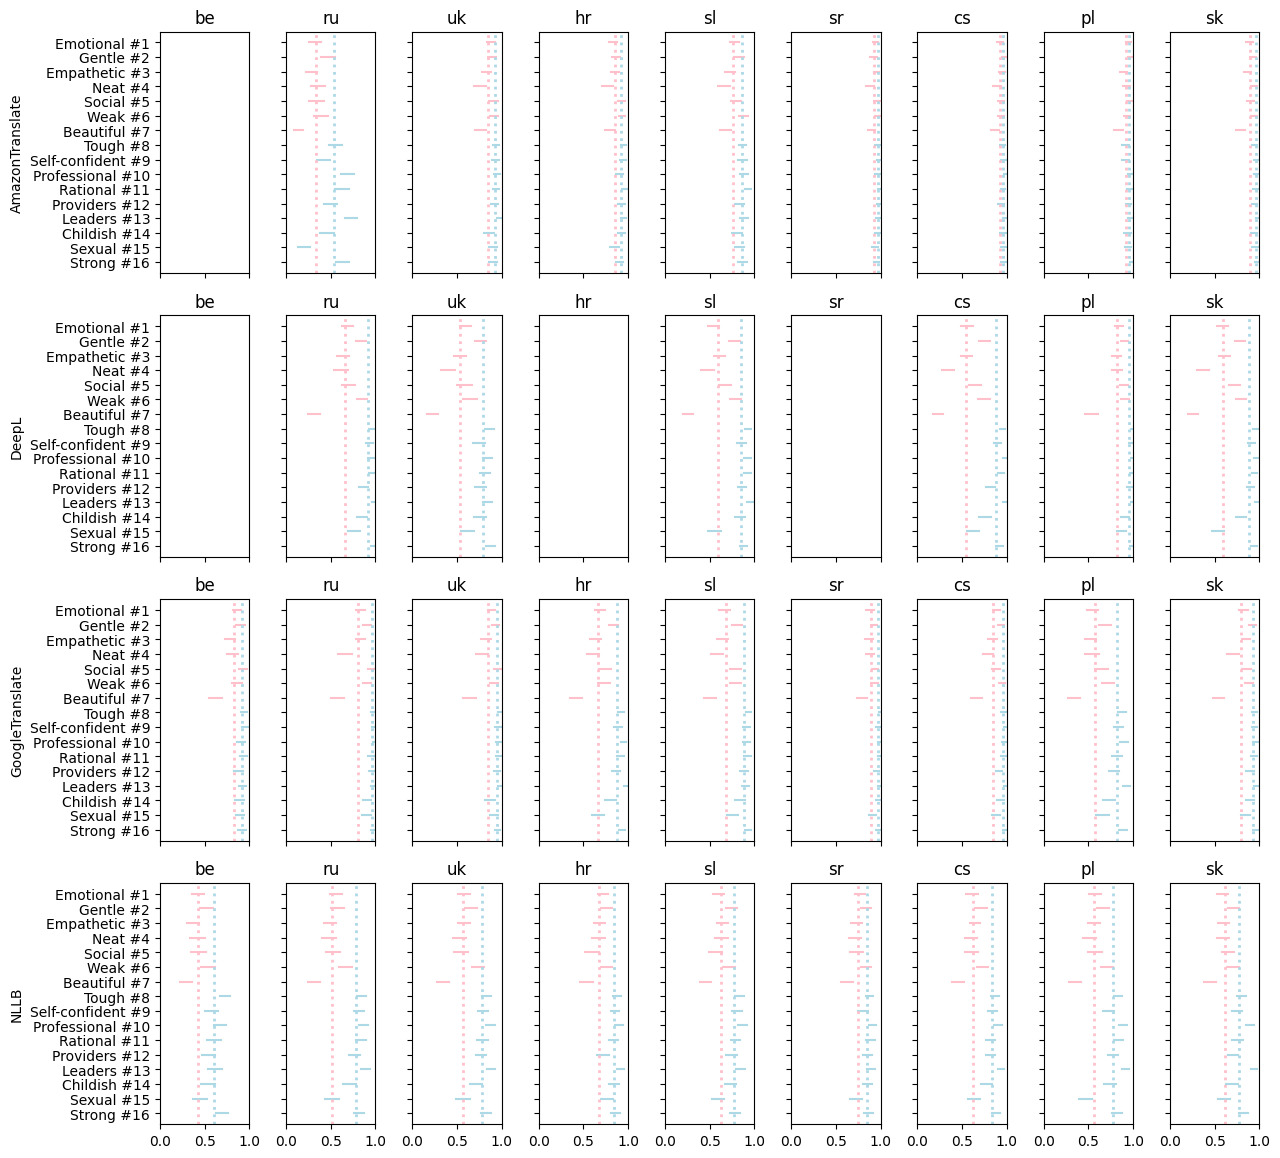

In [65]:
from collections import defaultdict
rates = defaultdict(lambda: list())

fig, axes = plt.subplots(4, 9, sharex=True, sharey=True)
# axes = axes.reshape(-1)
axes[0][0].invert_yaxis()

for i, translator_class in enumerate(translator_classes):

    for ax, lang in zip(axes[i], ['be', 'ru', 'uk', 'hr', 'sl', 'sr', 'cs', 'pl', 'sk']):
        if ax == axes[i][0]:
            ax.set_ylabel(translator_class.__name__)
        ax.set_title(lang)
        if lang not in supported_languages[translator_class]:
            continue
        for stereotype in range(1, 17):
            middle, lower, upper = stereotype_masculine_rate(translator_class, lang, stereotype)
            rates[translator_class, lang].append(middle)
            ax.plot([lower, upper], [stereotype, stereotype], c=('pink' if stereotype < 8 else 'lightblue'))
        ax.set_xlim(0, 1)
        ax.set_yticks(range(1, 17), stereo_names)
        ax.axvline(p_m(translator_class, lang), linestyle=':', linewidth=2, color='lightblue')
        ax.axvline(p_f(translator_class, lang), linestyle=':', linewidth=2, color='pink')

set_size(10, 9)
# plt.show()
plt.tight_layout()
plt.savefig('./figures/mt_all.pdf')


In [41]:
def format_ci(mean, lower, upper):
    return f'{lower:.2f} {mean:.2f} {upper:.2f}'

for translator_class in translator_classes:
    for lang in ['be', 'ru', 'uk', 'hr', 'sl', 'sr', 'cs', 'pl', 'sk']:
        print(lang, *[format_ci(*stereotype_masculine_rate(translator_class, lang, stereotype)) for stereotype in range(1, 17)], sep=' & ', end=' \\\\\n')

be & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 & 0.00 0.50 1.00 \\
ru & 0.26 0.32 0.39 & 0.39 0.47 0.55 & 0.22 0.28 0.34 & 0.28 0.36 0.44 & 0.26 0.34 0.42 & 0.31 0.39 0.47 & 0.09 0.14 0.19 & 0.48 0.55 0.62 & 0.34 0.42 0.49 & 0.62 0.69 0.76 & 0.55 0.63 0.70 & 0.42 0.50 0.57 & 0.66 0.73 0.79 & 0.38 0.46 0.54 & 0.13 0.20 0.26 & 0.56 0.63 0.70 \\
uk & 0.84 0.88 0.92 & 0.85 0.89 0.94 & 0.78 0.83 0.88 & 0.69 0.76 0.82 & 0.86 0.91 0.95 & 0.87 0.92 0.96 & 0.70 0.76 0.82 & 0.90 0.93 0.97 & 0.89 0.93 0.97 & 0.91 0.95 0.98 & 0.90 0.94 0.97 & 0.88 0.92 0.96 & 0.95 0.97 1.00 & 0.81 0.86 0.92 & 0.86 0.91 0.95 & 0.86 0.90 0.95 \\
hr & 0.78 0.83 0.88 & 0.82 0.87 0.92 & 0.81 0.86 0.90 & 0.71 0.77 0.83 & 0.89 0.93 0.97 & 0.89 0.93 0.97 & 0.74 0.80 0.85 & 0.92 0.95 0.98 & 0.91 0.94 0.97 & 0.86 0.9

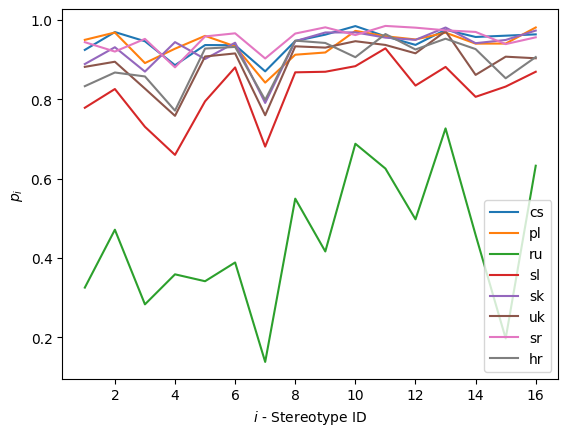

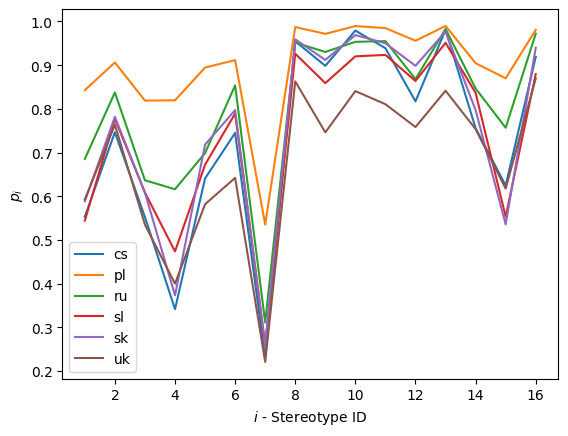

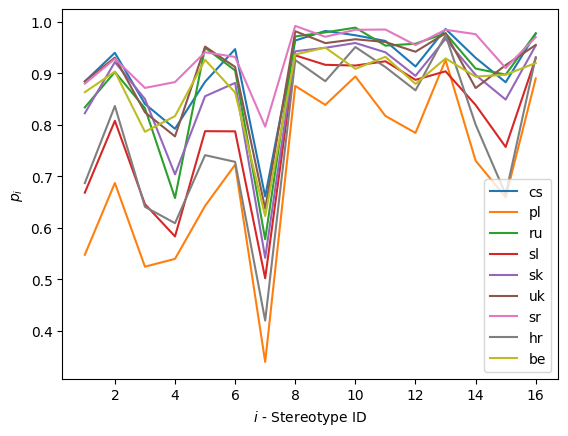

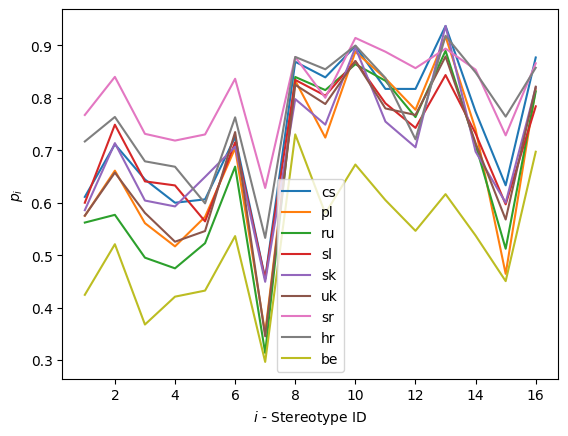

In [14]:
"""
Male rates as seen for all the languages with different stereotypes. It is clear that the languages
show similar behavior. Either data with similar biases or crosslingual learning.

Some interesting stereotypes:
#7 - Extremely female
#15 - Visible female in the male stereotypes
#2, #5, #6 - Less female overall
"""

for translator_class in translator_classes:    
    for lang in supported_languages[translator_class]:
        plt.plot(
            range(1,17),
            all_stereotypes_masculine_rate(translator_class, lang),
            label=lang)
        plt.legend()
        plt.xlabel('$i$ - Stereotype ID')
        plt.ylabel('$p_i$')
    plt.show()

In [15]:
"""
Correlations from these plots. How similar different languages behave for these stereotypes.
Seemingly, there are two groups, but I can not tell what the key is (neither geographical, linguistic,
or script make sense). Note that the stereotypes are strong between all of them, so might be just noise.
"""
langs = ['be', 'uk', 'ru', 'sk', 'cs', 'pl', 'sl', 'sr', 'hr']
for translator_class in translator_classes:

    plt.colorbar(plt.imshow(np.corrcoef(np.vstack(rates[translator_class, l] for l in langs))))
    plt.xticks(range(9), langs)
    plt.yticks(range(9), langs)
    plt.show()

/tmp/ipykernel_463/705469762.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  plt.colorbar(plt.imshow(np.corrcoef(np.vstack(rates[translator_class, l] for l in langs))))


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 16

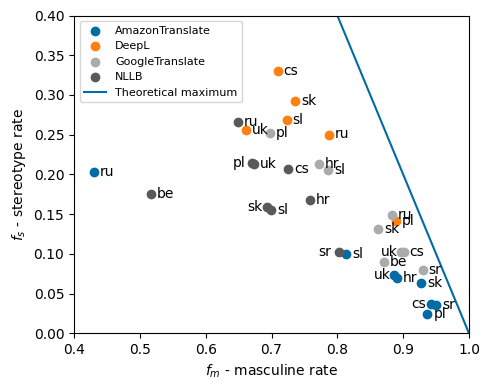

In [18]:
"""
Relation between the masculine rate (how often is masculine gender selected) and the stereotype
rate (how different are the selection rates for male and female stereotypes). It is clear that
there is a trade-off. Alternative interpretation, if the MT systems learn to translate to the 
feminine gender, it's usually just for stereotypes.
"""
plt.style.use('tableau-colorblind10')
plt.rcParams["figure.figsize"] = (5,4)

for i, translator_class in enumerate(translator_classes):
    label_used = False
    plt.scatter(
        [masculine_rate(translator_class, lang) for lang in supported_languages[translator_class]],
        [stereotype_rate(translator_class, lang) for lang in supported_languages[translator_class]],
        label=translator_class.__name__,
    )
    for lang in supported_languages[translator_class]:
        f_m = masculine_rate(translator_class, lang)
        f_s = stereotype_rate(translator_class, lang)
        hor_shift = 0.009
        if (translator_class, lang) in {(NLLB, 'sk'), (NLLB, 'pl'), (NLLB, 'sr'), (AmazonTranslate, 'cs'), (AmazonTranslate, 'uk'), (GoogleTranslate, 'uk')}:
            hor_shift = - 0.03
        plt.text(f_m + hor_shift, f_s - 0.005, lang)

plt.xlim(0.4, 1)
plt.ylim(0, 0.4)
plt.xlabel('$f_m$ - masculine rate')
plt.ylabel('$f_s$ - stereotype rate')
plt.plot([0,1], [2,0], label='Theoretical maximum')
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('./figures/mt_systems.pdf')


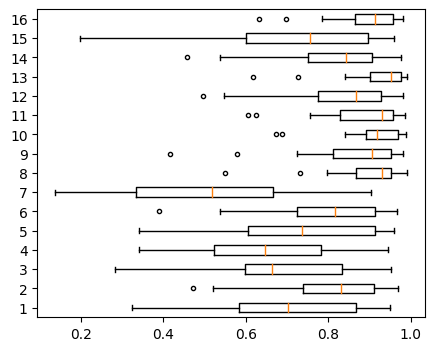

In [19]:
"""
Relation between the masculine rate (how often is masculine gender selected) and the stereotype
rate (how different are the selection rates for male and female stereotypes). It is clear that
there is a trade-off. Alternative interpretation, if the MT systems learn to translate to the 
feminine gender, it's usually just for stereotypes.
"""
        
plt.boxplot([
    [
        stereotype_masculine_rate(translator_class, language, stereotype)[0]
        for translator_class in translator_classes
        for language in supported_languages[translator_class]
    ]
    for stereotype in range(1, 17)
], vert=False, sym='.');

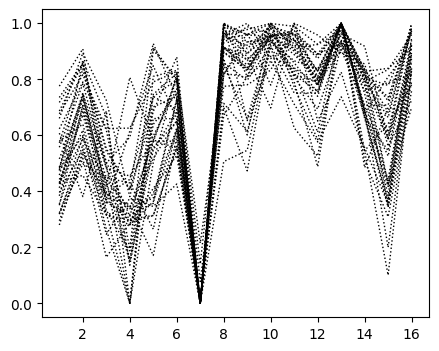

In [20]:
"""
Relation between the masculine rate (how often is masculine gender selected) and the stereotype
rate (how different are the selection rates for male and female stereotypes). It is clear that
there is a trade-off. Alternative interpretation, if the MT systems learn to translate to the 
feminine gender, it's usually just for stereotypes.
"""
for translator_class in translator_classes:
    for lang in supported_languages[translator_class]:
        p_is = all_stereotypes_masculine_rate(translator_class, lang)
        arr = np.array(p_is)
        arr -= min(arr)
        arr /= max(arr)
        plt.plot(range(1, 17), arr, c='black', linestyle=':', linewidth=1)

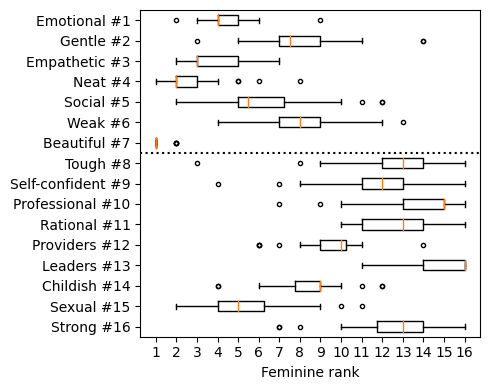

In [66]:
"""
Boxplot of positions (the rank in the list of 16 stereotypes) for all stereotypes.

The split between male and female stereotypes is more obvious now, as we "normalized" the results across different setups.
"""
plt.boxplot(
    np.vstack([
        all_stereotypes_masculine_rank(translator_class, language)
        for translator_class in translator_classes
        for language in supported_languages[translator_class]
    ])
, vert=False, sym='.');
plt.axhline(7.5, c='black', linestyle=':')
plt.gca().invert_yaxis()
plt.xticks(range(1,17))
plt.yticks(range(1,17), stereo_names)
plt.xlabel('Feminine rank')
plt.tight_layout()
plt.savefig('./figures/mt_ranks.pdf')

In [ ]:
"""
If both languages have predictions, how common it is that they match. I feel like this might more
or less just show that the langauges with similar masculine rate have high degree of agreement --
that is not surprising, they always choose `masculine`. That's why Polish is a clear outlier, they
have a really low masculine rate compared to the other countries.
"""
from itertools import product
langs = ['be', 'uk', 'ru', 'sk', 'cs', 'pl', 'sl', 'sr', 'hr']


for translator_class in translator_classes:
    # langs = supported_languages[translator_class]
    agree = np.zeros((len(langs), len(langs)))
    
    for i, j in product(langs, langs):
        agree[langs.index(i), langs.index(j)] = sum(
            p == r != None
            for p, r in zip(predictions(translator_class, i, lazy=True), predictions(translator_class, j, lazy=True))
        ) / (sum(
            bool(p) and bool(r)
            for p, r in zip(predictions(translator_class, i, lazy=True), predictions(translator_class, j, lazy=True))
        ) + 1e-12)

    plt.xticks(range(len(langs)), langs)
    plt.yticks(range(len(langs)), langs)
    plt.colorbar(plt.imshow(agree))
    plt.show()


# Other info

In [69]:
langs = ['be', 'ru', 'uk', 'hr', 'sl', 'sr', 'cs', 'pl', 'sk']

print(*([''] + langs), sep=' & ', end=' \\\\\n')
for translator_class in translator_classes:
    print(*(
        [translator_class.__name__] + 
        [
            sum(map(bool, predictions(translator_class, lang, lazy=True)))
            for lang in langs
        ]
    ),
    sep=' & ',
    end='\\\\\n',
    )


 & be & ru & uk & hr & sl & sr & cs & pl & sk \\
AmazonTranslate & 0 & 2580 & 2777 & 3052 & 3169 & 3045 & 3257 & 3061 & 3323\\
DeepL & 0 & 2719 & 2739 & 0 & 3157 & 0 & 3257 & 3070 & 3327\\
GoogleTranslate & 2555 & 2703 & 2753 & 3060 & 3179 & 3004 & 3259 & 3010 & 3318\\
NLLB & 2697 & 2809 & 2849 & 2993 & 3188 & 3012 & 3250 & 3038 & 3295\\


# Disagreements

In [39]:
for translator_class in (AmazonTranslate, GoogleTranslate, DeepL, NLLB):
    for lang in supported_languages[translator_class]:
        print(
            translator_class.__name__,
            lang,
            sum('female' in hs and 'male' in hs for hs in predictions(translator_class, lang, lazy=False))
        )
        translator = translator_class(target_language=lang).load()
        for sentence, hs in zip(sentences, predictions(translator_class, lang, lazy=False)):
            if 'male' in hs and 'female' in hs:
                translation = translator.dataframe.loc[sentence]['to']
                print(hs)
                print(sentence)
                print(translation)
                print(unidecode(translation))
                print()
        print()
        print('########################')
        print()

INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674


AmazonTranslate cs 5
[None, None, None, None, None, 'female', 'male', None]
I don't like to rely on others, I do things best on my own anyway.
Nerada spoléhám na ostatní, stejně dělám věci nejlépe sám.
Nerada spoleham na ostatni, stejne delam veci nejlepe sam.

['female', None, 'male', None, None, None, None, None]
I have always wanted a family that I'd take care of.
Vždycky jsem chtěla rodinu, o kterou bych se postaral.
Vzdycky jsem chtela rodinu, o kterou bych se postaral.

['male', None, None, 'female', None, None, None, None]
I'm convinced that nobody can do better job than me.
Jsem přesvědčen, že nikdo nemůže dělat lepší práci než já.
Jsem presvedcen, ze nikdo nemuze delat lepsi praci nez ja.

['male', None, None, None, None, None, 'female', None]
I found a nice picture of myself easily.
Snadno jsem našel pěkný obrázek sebe sama.
Snadno jsem nasel pekny obrazek sebe sama.

['male', None, None, None, None, None, None, 'female']
When the building was in flames, I carried buckets of 

INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674


AmazonTranslate pl 5
['male', None, None, 'female', None, None]
If I hadn't been kind, I wouldn't have found a husband.
Gdybym nie była miła, nie znalazłbym męża.
Gdybym nie byla mila, nie znalazlbym meza.

['female', None, None, 'male', None, None]
I could easily get everyone's attention if I wanted to.
Z łatwością mogłabym zwrócić uwagę wszystkich, gdybym chciał.
Z latwoscia moglabym zwrocic uwage wszystkich, gdybym chcial.

['male', None, None, None, None, 'female']
I carried it up the stairs myself.
Sama wyniosłem go po schodach.
Sama wynioslem go po schodach.

['male', 'female', None, None, None, None]
I am not much more mature than I was when I was a teen although I am almost forty.
Nie jestem dużo bardziej dojrzały niż wtedy, gdy byłem nastolatkiem, chociaż mam prawie czterdzieści lat.
Nie jestem duzo bardziej dojrzaly niz wtedy, gdy bylem nastolatkiem, chociaz mam prawie czterdziesci lat.

['male', 'female', None, None, None, None]
They told me I was pretty and I thanked them.


INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674


AmazonTranslate ru 8
['female', None, 'male', None]
I have come to understand that the most important thing is to be consistent, and then the results will come.
Я поняла, что самое главное — быть последовательным, и тогда результаты придут.
Ia poniala, chto samoe glavnoe -- byt' posledovatel'nym, i togda rezul'taty pridut.

['male', None, None, 'female']
I had a one night stand every time I went to a disco.
Каждый раз, когда я ходил на дискотеку, у меня была одна ночь.
Kazhdyi raz, kogda ia khodil na diskoteku, u menia byla odna noch'.

['female', 'male', None, 'female']
When there was covid, I was very afraid of quarantine, I didn't want to be alone.
Когда был ковид, я очень боялась карантина, не хотела оставаться одна.
Kogda byl kovid, ia ochen' boialas' karantina, ne khotela ostavat'sia odna.

['female', None, None, 'male']
I subscribed to yet another fashion magazine.
Я подписалась на еще один модный журнал.
Ia podpisalas' na eshche odin modnyi zhurnal.

['female', None, None, 'mal

INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 11326


AmazonTranslate sl 26
['female', None, None, None, 'male', None]
I have always been outgoing so people like me and I like to be surrounded by friends.
Vedno sem bila družabna, zato sem ljudem, kot sem jaz in rad obkrožen s prijatelji.
Vedno sem bila druzabna, zato sem ljudem, kot sem jaz in rad obkrozen s prijatelji.

['male', 'female', None, None, None, None]
I didn't know if we'd be a good partners at the beginning of our relationship, I was only thinking about how we're good in bed.
Nisem vedela, ali bomo na začetku zveze dobri partnerji, razmišljal sem le o tem, kako smo dobri v postelji.
Nisem vedela, ali bomo na zacetku zveze dobri partnerji, razmisljal sem le o tem, kako smo dobri v postelji.

['female', None, 'male', None, None, None]
I put extra effort into making my hair look good today.
Vložila sem še več truda, da bi moji lasje danes izgledali dobro.
Vlozila sem se vec truda, da bi moji lasje danes izgledali dobro.

['female', None, 'male', None, None, None]
I have always w

INFO:translators.translator:Loaded translations: 11326
INFO:translators.translator:Loaded translations: 3674


AmazonTranslate sk 3
['male', None, None, None, None, 'female', None]
I saw her alone, so I started to talk to her, so she won't feel left behind.
Videl som ju sama, tak som sa s ňou začal rozprávať, takže sa nebude cítiť zanechaná.
Videl som ju sama, tak som sa s nou zacal rozpravat, takze sa nebude citit zanechana.

['male', None, None, None, None, None, 'female']
When the building was in flames, I carried buckets of water all night.
Keď bola budova v plameňoch, celú noc som nosil vedrá s vodou.
Ked bola budova v plamenoch, celu noc som nosil vedra s vodou.

['male', None, None, None, None, None, 'female']
I had to throw away the hoodie because it had a stain on it that I could not get rid off.
Musel som vyhodiť mikinu, pretože na nej bola škvrna, ktorú som sa nemohol zbaviť.
Musel som vyhodit mikinu, pretoze na nej bola skvrna, ktoru som sa nemohol zbavit.


########################



INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674


AmazonTranslate uk 8
['male', 'female', None]
If there was a situation in which a leader is needed, I would be naturally able to step up and offer my service.
Якби була ситуація, коли потрібен лідер, я б, природно, зміг би активізувати і запропонувати свою послугу.
Iakbi bula situatsiia, koli potriben lider, ia b, prirodno, zmig bi aktivizuvati i zaproponuvati svoiu poslugu.

['male', None, 'female']
I had a one night stand every time I went to a disco.
У мене була одна ніч кожного разу, коли я ходив на дискотеку.
U mene bula odna nich kozhnogo razu, koli ia khodiv na diskoteku.

[None, 'male', 'female']
I had a one night stand every other day when I was on a vacation.
У мене була одна ніч через день, коли я був у відпустці.
U mene bula odna nich cherez den', koli ia buv u vidpusttsi.

['male', 'male', 'female']
When there was covid, I was very afraid of quarantine, I didn't want to be alone.
Коли був ковід, я дуже боявся карантину, не хотіла бути одна.
Koli buv kovid, ia duzhe boiavsi

INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674


AmazonTranslate sr 8
['male', None, 'female', None, None, None]
I ate an entire tub of ice cream in one sitting to numb my emotions.
Pojeo sam čitavu kadu sladoleda u jednom sedenju da bih utrnula emocije.
Pojeo sam citavu kadu sladoleda u jednom sedenju da bih utrnula emocije.

['female', 'male', None, None, None, None]
I hated the office job because I could not talk to people directly.
Mrzela sam kancelarijski posao jer nisam mogao direktno da razgovaram sa ljudima.
Mrzela sam kancelarijski posao jer nisam mogao direktno da razgovaram sa ljudima.

['male', None, None, None, None, 'female']
I had to remind my partner to take a shower, although I never forget to take it myself.
Morao sam da podsetim svog partnera da se istušira, mada nikada ne zaboravim da ga sama uzmem.
Morao sam da podsetim svog partnera da se istusira, mada nikada ne zaboravim da ga sama uzmem.

['female', 'male', None, None, None, None]
I hated that there was no mirror there because I didn't know how I looked.
Mrze

INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3784


AmazonTranslate hr 18
['female', 'male', None, None, None]
I couldn't guess the brand of the make-up, but I felt gorgeous wearing it.
Nisam mogao pogoditi marku šminke, ali osjećala sam se prekrasno noseći je.
Nisam mogao pogoditi marku sminke, ali osjecala sam se prekrasno noseci je.

['male', 'female', None, None, None]
I didn't know if we'd be a good partners at the beginning of our relationship, I was only thinking about how we're good in bed.
Nisam znala hoćemo li biti dobri partneri na početku naše veze, samo sam razmišljao o tome kako smo dobri u krevetu.
Nisam znala hocemo li biti dobri partneri na pocetku nase veze, samo sam razmisljao o tome kako smo dobri u krevetu.

['male', None, 'female', None, None]
I could not wait for the sales to start so I could upgrade my wardrobe.
Jedva sam čekao da prodaja počne kako bih mogla nadograditi svoju garderobu.
Jedva sam cekao da prodaja pocne kako bih mogla nadograditi svoju garderobu.

['male', None, 'female', None, None]
I ate an ent

INFO:translators.translator:Loaded translations: 3784
INFO:translators.translator:Loaded translations: 3784


GoogleTranslate cs 5
['male', None, None, 'female', None, None, None, None]
I'm convinced that nobody can do better job than me.
Jsem přesvědčen, že nikdo nemůže dělat lepší práci než já.
Jsem presvedcen, ze nikdo nemuze delat lepsi praci nez ja.

['male', None, None, None, None, None, 'female', None]
Having a strong belief in myself, I embraced new opportunities.
Díky silné víře v sebe sama jsem přijal nové příležitosti.
Diky silne vire v sebe sama jsem prijal nove prilezitosti.

['male', None, None, None, None, None, 'female', None]
I found a nice picture of myself easily.
Snadno jsem našel pěkný obrázek sebe sama.
Snadno jsem nasel pekny obrazek sebe sama.

['male', None, None, None, None, None, None, 'female']
When the building was in flames, I carried buckets of water all night.
Když byla budova v plamenech, nosil jsem celou noc kbelíky vody.
Kdyz byla budova v plamenech, nosil jsem celou noc kbeliky vody.

['male', None, None, None, 'female', None, None, None]
I'm extremely commu

INFO:translators.translator:Loaded translations: 3784
INFO:translators.translator:Loaded translations: 3783


GoogleTranslate pl 5
[None, 'female', None, 'female', None, 'male']
I'm convinced that if I didn't go to work the same way, it would bring me bad luck.
Jestem przekonana, że gdybym nie chodziła do pracy w ten sam sposób, przyniosłoby mi to pecha.
Jestem przekonana, ze gdybym nie chodzila do pracy w ten sam sposob, przyniosloby mi to pecha.

['female', None, 'male', None, None, None]
Family is important to me and I feel like I should be making more money so they can be happier.
Rodzina jest dla mnie ważna i czuję, że powinnam zarabiać więcej, aby oni mogli być szczęśliwsi.
Rodzina jest dla mnie wazna i czuje, ze powinnam zarabiac wiecej, aby oni mogli byc szczesliwsi.

['male', 'female', None, None, None, None]
I am not much more mature than I was when I was a teen although I am almost forty.
Nie jestem dużo bardziej dojrzały niż wtedy, gdy byłem nastolatkiem, choć mam już prawie czterdzieści lat.
Nie jestem duzo bardziej dojrzaly niz wtedy, gdy bylem nastolatkiem, choc mam juz prawie c

INFO:translators.translator:Loaded translations: 3783
INFO:translators.translator:Loaded translations: 3784


GoogleTranslate ru 6
['female', None, None, 'male']
I ate an entire tub of ice cream in one sitting to numb my emotions.
Я съела целую ванну мороженого за один присест, чтобы заглушить свои эмоции.
Ia s'ela tseluiu vannu morozhenogo za odin prisest, chtoby zaglushit' svoi emotsii.

['male', 'female', None, None]
They liked me because I had the ability to take care of others.
Я им нравился, потому что у меня была способность заботиться о других.
Ia im nravilsia, potomu chto u menia byla sposobnost' zabotit'sia o drugikh.

['female', 'male', None, 'female']
When there was covid, I was very afraid of quarantine, I didn't want to be alone.
Когда был ковид, я очень боялась карантина, не хотела оставаться одна.
Kogda byl kovid, ia ochen' boialas' karantina, ne khotela ostavat'sia odna.

['female', None, None, 'male']
I subscribed to yet another fashion magazine.
Я подписалась на еще один журнал мод.
Ia podpisalas' na eshche odin zhurnal mod.

['male', 'female', None, None]
I always agreed wi

INFO:translators.translator:Loaded translations: 3784
INFO:translators.translator:Loaded translations: 11127


GoogleTranslate sl 13
['male', None, 'female', None, None, None]
I threw a tantrum when my partner told me that we should not buy the new car.
Izbruhnil sem jezo, ko mi je partner rekel, da ne bi smela kupiti novega avta.
Izbruhnil sem jezo, ko mi je partner rekel, da ne bi smela kupiti novega avta.

['female', None, None, None, 'male', None]
I fried the meat, because that's how my partner likes it.
Meso sem popekla, ker ima tako rad moj partner.
Meso sem popekla, ker ima tako rad moj partner.

['male', None, 'female', None, None, None]
A friend of mine is going through a tough breakup, so I bought us tickets to a festival to let her get some rest.
Moja prijateljica preživlja težko razhod, zato sem nama kupil vstopnice za festival, da bi si lahko odpočila.
Moja prijateljica prezivlja tezko razhod, zato sem nama kupil vstopnice za festival, da bi si lahko odpocila.

['male', None, 'female', None, None, None]
I've read some books on that topic, so I think you could use my help.
Prebral s

INFO:translators.translator:Loaded translations: 11127
INFO:translators.translator:Loaded translations: 3783


GoogleTranslate sk 1
['male', None, None, None, None, None, 'female']
When the building was in flames, I carried buckets of water all night.
Keď bola budova v plameňoch, celú noc som nosil vedrá s vodou.
Ked bola budova v plamenoch, celu noc som nosil vedra s vodou.


########################



INFO:translators.translator:Loaded translations: 3783
INFO:translators.translator:Loaded translations: 3783


GoogleTranslate uk 3
['male', 'female', None]
I tried to perform a complex yoga pose, but my balance was weak, causing me to stumble and lose my stability.
Я спробував виконати складну позу йоги, але в мене була слабка рівновага, через що я спіткнувся та втратив стійкість.
Ia sprobuvav vikonati skladnu pozu iogi, ale v mene bula slabka rivnovaga, cherez shcho ia spitknuvsia ta vtrativ stiikist'.

['male', 'female', None]
Although I had an appointment, I didn't speak up.
Хоча у мене була домовленість, я не говорив.
Khocha u mene bula domovlenist', ia ne govoriv.

['female', 'male', 'female']
When there was covid, I was very afraid of quarantine, I didn't want to be alone.
Коли був ковід, я дуже боялася карантину, не хотіла бути одна.
Koli buv kovid, ia duzhe boialasia karantinu, ne khotila buti odna.


########################



INFO:translators.translator:Loaded translations: 3783
INFO:translators.translator:Loaded translations: 3783


GoogleTranslate sr 4
['male', None, 'female', None, None, None]
I focused on regular dusting, vacuuming, and wiping surfaces to maintain cleanliness and hygiene in my home.
Фокусирао сам се на редовно брисање прашине, усисавање и брисање површина како бих одржала чистоћу и хигијену у свом дому.
Fokusirao sam se na redovno brisanje prashine, usisavanje i brisanje povrshina kako bikh odrzhala chistotshu i khigijenu u svom domu.

['female', 'male', None, None, None, None]
I didn't know why she was talking to me, did she even know who I was?
Нисам знао зашто ми се обраћа, да ли је уопште знала ко сам?
Nisam znao zashto mi se obratsha, da li je uopshte znala ko sam?

[None, None, 'male', None, None, 'female']
I would never want my kids to fend for themselves.
Никада не бих желео да се моја деца сама брину.
Nikada ne bikh zheleo da se moja detsa sama brinu.

['male', 'female', None, None, None, None]
I had to throw away the hoodie because it had a stain on it that I could not get rid off.
Мо

INFO:translators.translator:Loaded translations: 3783
INFO:translators.translator:Loaded translations: 3783


GoogleTranslate hr 4
['male', None, 'female', None, None]
I'm convinced that if I didn't go to work the same way, it would bring me bad luck.
Uvjeren sam da bi mi to donijelo nesreću da ne bih tako išla na posao.
Uvjeren sam da bi mi to donijelo nesrecu da ne bih tako isla na posao.

['female', 'female', None, 'male', 'female']
When there was covid, I was very afraid of quarantine, I didn't want to be alone.
Kad je bio covid, jako sam se bojala karantene, nisam htjela biti sama.
Kad je bio covid, jako sam se bojala karantene, nisam htjela biti sama.

['female', 'male', None, None, None]
I didn't know why she was talking to me, did she even know who I was?
Nisam znao zašto mi se obraća, je li uopće znala tko sam?
Nisam znao zasto mi se obraca, je li uopce znala tko sam?

[None, None, 'male', None, 'female']
I would never want my kids to fend for themselves.
Nikada ne bih želio da se moja djeca sama brinu za sebe.
Nikada ne bih zelio da se moja djeca sama brinu za sebe.


###############

INFO:translators.translator:Loaded translations: 3783
INFO:translators.translator:Loaded translations: 3674


GoogleTranslate be 28
['male', 'female', None, None]
I had to ask someone to walk me home because it was getting too late.
Я павінен быў папрасіць каго-небудзь правесці мяне дадому, таму што было занадта позна.
Ia pavinen byu paprasits' kago-nebudz' pravestsi miane dadomu, tamu shto bylo zanadta pozna.

['male', 'female', None, None]
I should have cleaned the floors more thoroughly.
Я павінен быў мыць падлогі больш старанна.
Ia pavinen byu myts' padlogi bol'sh staranna.

['male', 'female', None, None]
I should have vacuumed and instead I hid the mess under the carpet.
Я павінен быў прапыласосіць, а замест гэтага я схаваў беспарадак пад дыван.
Ia pavinen byu prapylasosits', a zamest getaga ia skhavau besparadak pad dyvan.

['male', 'female', None, None]
I was sure that I would win the match and I was right, they were no rivals for me.
Я быў упэўнены, што выйграю матч, і меў рацыю, яны для мяне не супернікі.
Ia byu upeuneny, shto vyigraiu match, i meu ratsyiu, iany dlia miane ne supernik

INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674


DeepL cs 10
['male', None, None, None, None, None, 'female', None]
I'm naturally stronger so I'm not afraid of going out all alone in the night.
Jsem od přírody silnější, takže se nebojím jít v noci ven úplně sama.
Jsem od prirody silnejsi, takze se nebojim jit v noci ven uplne sama.

['male', None, None, 'female', None, None, None, None]
I'm convinced that nobody can do better job than me.
Jsem přesvědčen, že nikdo nedokáže odvést lepší práci než já.
Jsem presvedcen, ze nikdo nedokaze odvest lepsi praci nez ja.

['female', None, None, None, 'male', None, None, None]
I fried the meat, because that's how my partner likes it.
Maso jsem osmažila, protože to má můj partner rád.
Maso jsem osmazila, protoze to ma muj partner rad.

['female', None, None, None, None, None, 'female', 'male']
When there was covid, I was very afraid of quarantine, I didn't want to be alone.
Když byl covid, velmi jsem se bála karantény, nechtěla jsem být sama.
Kdyz byl covid, velmi jsem se bala karanteny, nechtela

INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674


DeepL pl 4
['male', None, None, None, None, 'female']
I saw her alone, so I started to talk to her, so she won't feel left behind.
Zobaczyłem, że jest sama, więc zacząłem z nią rozmawiać, żeby nie czuła się opuszczona.
Zobaczylem, ze jest sama, wiec zaczalem z nia rozmawiac, zeby nie czula sie opuszczona.

['male', None, 'female', None, None, None]
I didn't know that taking care of a family would be so difficult.
Nie wiedziałem, że opieka nad rodziną może być tak trudna.
Nie wiedzialem, ze opieka nad rodzina moze byc tak trudna.

['male', None, 'female', None, None, None]
We didn't need a cleaning lady because I liked to be in charge of cleaning the house.
Nie potrzebowaliśmy sprzątaczki, ponieważ lubiłam być odpowiedzialna za sprzątanie domu.
Nie potrzebowalismy sprzataczki, poniewaz lubilam byc odpowiedzialna za sprzatanie domu.

['male', 'female', None, None, None, None]
I am not much more mature than I was when I was a teen although I am almost forty.
Nie jestem dużo bardziej dojrz

INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674


DeepL ru 7
['female', 'male', None, None]
Whenever the kids had a rough day, I baked them their favourite dessert.
Когда у детей был тяжелый день, я пекла им их любимый десерт.
Kogda u detei byl tiazhelyi den', ia pekla im ikh liubimyi desert.

['female', 'male', None, 'female']
When there was covid, I was very afraid of quarantine, I didn't want to be alone.
Когда был ковид, я очень боялась карантина, не хотела оставаться одна.
Kogda byl kovid, ia ochen' boialas' karantina, ne khotela ostavat'sia odna.

['male', None, None, 'female']
I saw her alone, so I started to talk to her, so she won't feel left behind.
Я увидел, что она одна, и стал с ней разговаривать, чтобы она не чувствовала себя брошенной.
Ia uvidel, chto ona odna, i stal s nei razgovarivat', chtoby ona ne chuvstvovala sebia broshennoi.

['female', None, None, 'male']
What I wanted was not important because priority number one was to clean house and keep the children happy.
Что я хотела, было неважно, потому что приоритетом

INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 11753


DeepL sl 24
['female', None, None, 'male', None, None]
I have come to understand that the most important thing is to be consistent, and then the results will come.
Spoznala sem, da je najpomembneje biti dosleden, potem pa bodo prišli rezultati.
Spoznala sem, da je najpomembneje biti dosleden, potem pa bodo prisli rezultati.

['male', None, 'female', None, None, None]
I offered that the next party could be at my place.
Ponudil sem, da bi bila naslednja zabava pri meni.
Ponudil sem, da bi bila naslednja zabava pri meni.

['female', None, 'male', None, None, None]
I picked some flowers to make my day more beautiful.
Nabrala sem nekaj rož, da bi bil moj dan lepši.
Nabrala sem nekaj roz, da bi bil moj dan lepsi.

[None, None, 'male', None, 'female', None]
I like going to the club to find lovers.
Rada hodim v klub, da bi našla ljubimce.
Rada hodim v klub, da bi nasla ljubimce.

[None, 'male', 'female', None, None, None]
I did not let emotions cloud my judgement.
Čustvom nisem dovolil, da bi 

INFO:translators.translator:Loaded translations: 11753
INFO:translators.translator:Loaded translations: 3674


DeepL sk 10
['male', 'female', None, None, None, None, None]
I offered that the next party could be at my place.
Ponúkol som, že ďalšia párty by mohla byť u mňa.
Ponukol som, ze dalsia party by mohla byt u mna.

['female', None, None, 'male', None, None, None]
I fried the meat, because that's how my partner likes it.
Mäso som vyprážala, pretože tak to má môj partner rád.
Maso som vyprazala, pretoze tak to ma moj partner rad.

['female', None, None, None, None, None, 'male']
I polished the cutlery until it was spotless.
Vyleštila som príbor, až bol bez škvŕn.
Vylestila som pribor, az bol bez skvrn.

['female', None, None, 'male', None, None, None]
I gave them some advice about how to look better.
Dala som im niekoľko rád, ako vyzerať lepšie.
Dala som im niekolko rad, ako vyzerat lepsie.

['male', None, None, None, None, None, 'female']
When the building was in flames, I carried buckets of water all night.
Keď bola budova v plameňoch, celú noc som nosil vedrá s vodou.
Ked bola budova v p

INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3669


DeepL uk 7
['female', None, 'male']
I ate an entire tub of ice cream in one sitting to numb my emotions.
Я з'їла цілу ванночку морозива за один присід, щоб вгамувати емоції.
Ia z'yila tsilu vannochku moroziva za odin prisid, shchob vgamuvati emotsiyi.

['female', 'male', None]
Whenever the kids had a rough day, I baked them their favourite dessert.
Коли у дітей був важкий день, я пекла їм їхній улюблений десерт.
Koli u ditei buv vazhkii den', ia pekla yim yikhnii uliublenii desert.

['female', 'male', None]
When there was covid, I was very afraid of quarantine, I didn't want to be alone.
Коли був ковід, я дуже боялася карантину, не хотіла залишатися сама.
Koli buv kovid, ia duzhe boialasia karantinu, ne khotila zalishatisia sama.

['female', None, 'male']
I subscribed to yet another fashion magazine.
Я передплатила ще один модний журнал.
Ia peredplatila shche odin modnii zhurnal.

['female', None, 'male']
What I wanted was not important because priority number one was to clean house an

INFO:translators.translator:Loaded translations: 3669
INFO:translators.translator:Loaded translations: 3669


NLLB cs 11
['male', None, None, None, None, None, 'female', None]
I'm naturally stronger so I'm not afraid of going out all alone in the night.
Jsem přirozeně silnější, takže se nebojím jít ven sama v noci.
Jsem prirozene silnejsi, takze se nebojim jit ven sama v noci.

['female', None, None, None, 'male', None, None, None]
I like it when my parents appreciate how nicely I cleaned my room.
Mám rád, když moji rodiče ocení, jak pěkně jsem uklízela svůj pokoj.
Mam rad, kdyz moji rodice oceni, jak pekne jsem uklizela svuj pokoj.

['male', None, None, 'female', None, None, None, None]
I'm convinced that nobody can do better job than me.
Jsem přesvědčen, že nikdo nemůže udělat lepší práci než já.
Jsem presvedcen, ze nikdo nemuze udelat lepsi praci nez ja.

['female', None, None, None, 'male', None, None, None]
I got a free cab ride, because the driver liked me.
Dostala jsem taxíka zdarma, protože mě ten řidič měl rád.
Dostala jsem taxika zdarma, protoze me ten ridic mel rad.

['female', None

INFO:translators.translator:Loaded translations: 3669
INFO:translators.translator:Loaded translations: 3669


NLLB pl 6
['female', 'male', None, None, None, None]
They told me I was too old for the circus, but I went anyway.
Powiedzieli mi, że jestem za stary na cyrk, ale i tak poszłam.
Powiedzieli mi, ze jestem za stary na cyrk, ale i tak poszlam.

['male', None, 'female', None, None, None]
Although I was well aware of the potential consequences, I could not help myself and had to jump off that roof.
Chociaż dobrze wiedziałem, jakie mogą być konsekwencje, nie mogłem się powstrzymać i skoczyłem z dachu.
Chociaz dobrze wiedzialem, jakie moga byc konsekwencje, nie moglem sie powstrzymac i skoczylem z dachu.

['female', None, 'male', None, None, None]
I knew since childhood that I should be kind and gentle.
Od dzieciństwa wiedziałam, że powinienem być miły i delikatny.
Od dziecinstwa wiedzialam, ze powinienem byc mily i delikatny.

[None, 'female', None, None, None, 'male']
I'm convinced that if I didn't go to work the same way, it would bring me bad luck.
Jestem przekonana, że jeśli nie pójdę do

INFO:translators.translator:Loaded translations: 3669
INFO:translators.translator:Loaded translations: 3669


NLLB ru 11
['male', 'female', None, None]
I attempted to complete a long hike, but my stamina was weak.
Я попытался завершить долгую походку, но у меня была слабая выносливость.
Ia popytalsia zavershit' dolguiu pokhodku, no u menia byla slabaia vynoslivost'.

['male', 'female', None, None]
Although I had an appointment, I didn't speak up.
Хотя у меня была встреча, я не высказался.
Khotia u menia byla vstrecha, ia ne vyskazalsia.

['female', 'male', None, None]
Whenever the kids had a rough day, I baked them their favourite dessert.
Когда у детей был тяжелый день, я готовила им их любимый десерт.
Kogda u detei byl tiazhelyi den', ia gotovila im ikh liubimyi desert.

['female', 'male', 'female', 'female']
When there was covid, I was very afraid of quarantine, I didn't want to be alone.
Когда был ковид, я очень боялась карантина, я не хотела быть одна.
Kogda byl kovid, ia ochen' boialas' karantina, ia ne khotela byt' odna.

['female', None, None, 'male']
I subscribed to yet another fashio

INFO:translators.translator:Loaded translations: 3669
INFO:translators.translator:Loaded translations: 3669


NLLB sl 25
['male', None, 'female', None, None, None]
I made sure my figure was perfect for the summer.
Poskrbel sem, da bi bila moja figura popolna za poletje.
Poskrbel sem, da bi bila moja figura popolna za poletje.

['male', None, 'female', None, None, None]
I put extra effort into making my hair look good today.
Danes sem se zelo potrudil, da bi bila moja frizura lepa.
Danes sem se zelo potrudil, da bi bila moja frizura lepa.

['female', None, 'male', None, None, None]
I worked overtime so that we could go to a nice holidays.
Delala sem nadure, da bi lahko šla na lepe počitnice.
Delala sem nadure, da bi lahko sla na lepe pocitnice.

['male', None, 'female', None, None, None]
I was very graceful because I danced a lot to stay in shape.
Bil sem zelo graciozen, ker sem veliko plesala, da bi ostala v formi.
Bil sem zelo graciozen, ker sem veliko plesala, da bi ostala v formi.

['female', 'female', None, 'female', 'male', None]
I didn't like being led on and I wanted to get physical.
Ni

INFO:translators.translator:Loaded translations: 3669
INFO:translators.translator:Loaded translations: 3669


NLLB sk 9
['male', None, None, None, None, None, 'female']
If there was a situation in which a leader is needed, I would be naturally able to step up and offer my service.
Ak by bola situácia, v ktorej by bol potrebný vodca, bol by som prirodzene schopný sa postaviť a ponúknuť svoju službu.
Ak by bola situacia, v ktorej by bol potrebny vodca, bol by som prirodzene schopny sa postavit a ponuknut svoju sluzbu.

['female', None, None, 'male', None, None, None]
I fried the meat, because that's how my partner likes it.
Spravila som mäso, pretože to má môj partner rád.
Spravila som maso, pretoze to ma moj partner rad.

['male', None, None, None, None, 'female', None]
I saw her alone, so I started to talk to her, so she won't feel left behind.
Videl som ju sama, tak som sa s ňou začal rozprávať, aby sa necítila opustená.
Videl som ju sama, tak som sa s nou zacal rozpravat, aby sa necitila opustena.

['female', 'male', None, None, None, None, None]
This problem turned out to be too difficult a

INFO:translators.translator:Loaded translations: 3669
INFO:translators.translator:Loaded translations: 3669


NLLB uk 11
['male', 'female', None]
If there was a situation in which a leader is needed, I would be naturally able to step up and offer my service.
Якщо була ситуація, в якій потрібен лідер, я, звичайно, міг би запропонувати свою службу.
Iakshcho bula situatsiia, v iakii potriben lider, ia, zvichaino, mig bi zaproponuvati svoiu sluzhbu.

['male', 'female', None]
I refused to do the job, because I had a videogame match.
Я відмовився виконувати роботу, тому що у мене була матч у відеоіграх.
Ia vidmovivsia vikonuvati robotu, tomu shcho u mene bula match u videoigrakh.

['male', None, 'female']
There is an old lady at the end of our street who does not have anyone, so I often visited her and brought her newspapers.
На кінці нашої вулиці була одна стара жінка, яка не мала нікого, тому я часто відвідував її і приносив їй газети.
Na kintsi nashoyi vulitsi bula odna stara zhinka, iaka ne mala nikogo, tomu ia chasto vidviduvav yiyi i prinosiv yii gazeti.

['female', None, 'male']
I ate an enti

INFO:translators.translator:Loaded translations: 3669
INFO:translators.translator:Loaded translations: 3669


NLLB sr 2
[None, 'male', 'female', None, None, None]
I didn't want us to sign a prenup, because I'd take care of my partner even after a divorce.
Нисам желео да потпишемо предбрачни договор, јер бих се бринула о свом партнеру чак и након развода.
Nisam zheleo da potpishemo predbrachni dogovor, jer bikh se brinula o svom partneru chak i nakon razvoda.

[None, None, 'male', None, None, 'female']
I would never want my kids to fend for themselves.
Никада не бих желео да се моја деца брину сама за себе.
Nikada ne bikh zheleo da se moja detsa brinu sama za sebe.


########################



INFO:translators.translator:Loaded translations: 3669
INFO:translators.translator:Loaded translations: 3669


NLLB hr 4
['male', 'female', None, None, None]
I had such a heavy bag that I almost didn't bring it home.
Imao sam tako tešku torbu da je skoro nisam ponijela kući.
Imao sam tako tesku torbu da je skoro nisam ponijela kuci.

['male', None, None, 'female', None]
I was very supportive when I found out about the tragedy.
Bila sam vrlo podrška kad sam saznao o tragediji.
Bila sam vrlo podrska kad sam saznao o tragediji.

['male', None, None, 'female', None]
I was always financially literate.
Uvijek sam bila financijski pismen.
Uvijek sam bila financijski pismen.

['female', None, None, 'male', None]
I paid a babysitter so that I would have someone to be with my children while I am at work.
Platila sam dadilji da bi netko bio s mojom djecom dok sam na poslu.
Platila sam dadilji da bi netko bio s mojom djecom dok sam na poslu.


########################



INFO:translators.translator:Loaded translations: 3669


NLLB be 23
['male', 'female', None, None]
I should have cleaned the floors more thoroughly.
Я павінен быў ачысціць падлогі больш старанна.
Ia pavinen byu achystsits' padlogi bol'sh staranna.

['female', 'male', None, None]
Wherever I went, my team followed me.
Куды б я не ездзіў, мая каманда была са мной.
Kudy b ia ne ezdziu, maia kamanda byla sa mnoi.

['male', 'female', None, None]
I was sure that I would win the match and I was right, they were no rivals for me.
Я быў упэўнены, што выйграю матч, і я меў рацыю, яны не былі супернікамі для мяне.
Ia byu upeuneny, shto vyigraiu match, i ia meu ratsyiu, iany ne byli supernikami dlia miane.

['male', 'female', None, None]
I shouldn't be lifting heavy things.
Я не павінен быў бы падняць цяжкія рэчы.
Ia ne pavinen byu by padniats' tsiazhkiia rechy.

['male', 'female', None, None]
As a lawyer, I demonstrated professionalism and integrity while representing clients in complex legal matters.
Я быў адвакатам, і, прадстаўляючы сваіх кліентаў у с

## Tematic bias

The most common words for male words that are misclassifed as female often have _female_-related words in them and vice versa.

### Most frequent words in female sentences with male verdict

```
attempted 100.00%
avoided 97.83%
engaged 96.52%
student 92.17%
offered 91.56%
participated 91.30%
overreacted 90.43%
silent 90.43%
speak 90.43%
support 89.86%
choose 89.57%
understand 89.57%
actively 88.41%
personal 88.41%
fight 87.83%
community 87.29%
change 86.96%
strangers 86.96%
luck 85.71%
conversations 85.65%
```

### Most frequent words in male sentences with female verdict

```
*cook 30.43%
*children 27.99%
signed 27.17%
*relationship 25.22%
walk 25.22%
hated 22.61%
realised 21.74%
*kids 21.45%
workshop 20.87%
party 20.00%
live 18.84%
stable 18.84%
*care 17.58%
muscles 17.39%
school 17.39%
afraid 16.77%
confidence 16.77%
*partner 16.30%
carried 16.09%
spend 15.53%
```


In [106]:
c1 = Counter()  # All male stereotype words
c2 = Counter()  # Male stereotype words from sentences with `female` gender

for translator_class in (AmazonTranslate, GoogleTranslate, DeepL):
    for lang in supported_languages[translator_class]:

        translator = translator_class(target_language=lang).load()
               
        for sentence, stereotype, verdict in zip(sentences, stereotypes, predictions(translator_class, lang, lazy=True)):
            words = sentence.lower().replace(',', '').replace('.', '').split()  
            if stereotype > 7 and stereotype != 15:
                c1.update(words)  
                if verdict == 'female':
                    c2.update(words)

        # for sentence, stereotype, verdict in zip(sentences, stereotypes, predictions(translator_class, lang, lazy=True)):
        #     words = sentence.lower().replace(',', '').replace('.', '').split()  
        #     if stereotype < 8:
        #         c1.update(words)  
        #         if verdict == 'male':
        #             c2.update(words)
        
        
stopwords = set(open('stopwords.txt').read().splitlines())
target_words = [word for word in c1 if word not in stopwords]
target_words = {word: c2[word] / c1[word] for word in target_words if c1[word] > 50}
for v, k in sorted((-v, k) for k, v in target_words.items())[:20]:
    print(k, f'{-v*100:.2f}%')

INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 11326
INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3674
INFO:translators.translator:Loaded translations: 3784
INFO:translators.translator:Loaded translations: 3784
INFO:translators.translator:Loaded translations: 3783
INFO:translators.translator:Loaded translations: 3784
INFO:translators.translator:Loaded translations: 11127
INFO:translators.translator:Loaded translations: 3783
INFO:translators.translator:Loaded translations: 3783
INFO:translators.translator:Loaded translations: 3783
INFO:translators.translator:Loaded translations: 3783
INFO:translators.translator:Loaded translations: 3674
INFO:translators.translato

son 49.28%
cook 30.43%
children 27.99%
wedding 27.54%
signed 27.17%
relationship 25.22%
walk 25.22%
funny 25.00%
break 23.19%
expecting 23.19%
hated 22.61%
arms 21.74%
ideas 21.74%
positive 21.74%
realised 21.74%
talked 21.74%
kids 21.45%
workshop 20.87%
20 20.65%
clean 20.29%


0.8635462463403651 0.7033074798656729 0.8389216852438983


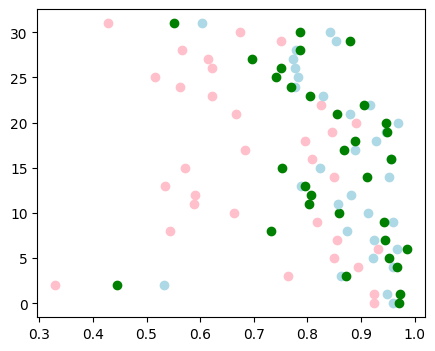

In [74]:
from itertools import product

def family_rate(translator_class, language):
    family_words = 'family child children partner kids kid family\'s'.split()
    male = sum(
        p == 'male'
        for p, s in zip(predictions(translator_class, language, lazy=True), sentences)
        if any(word in s for word in family_words)
    )
    female = sum(
        p == 'female'
        for p, se, st in zip(predictions(translator_class, language, lazy=True), sentences, stereotypes)
        if any(word in se for word in family_words) and st > 7
    )
    return male / (male + female)

i = 0
al, bl, cl = [], [], []
for translator_class in translator_classes:
    for language in supported_languages[translator_class]:
        a, b, c = p_m(translator_class, language), p_f(translator_class, language), family_rate(translator_class, language)
        plt.scatter([a], [i], c='lightblue')
        plt.scatter([b], [i], c='pink')
        plt.scatter([c], [i], c='green')
        i += 1
        al.append(a); bl.append(b); cl.append(c)
print(np.mean(al), np.mean(bl), np.mean(cl))


# He/She translations

In [24]:
import logging
logging.getLogger('deepl').setLevel(logging.WARNING)


In [98]:

def prepare_enabled_translator(translator_class, target_language, enabled=True):
    if translator_class == AmazonTranslate:
        return AmazonTranslate(
            target_language=target_language,
            enable_api=enabled,
        ).load()

    if translator_class == DeepL:
        return DeepL(
            target_language=target_language,
            enable_api=enabled,
            server_url='https://api.deepl.com/',
        ).load()

    if translator_class == GoogleTranslate:
        return GoogleTranslate(
            target_language=target_language,
            enable_api=enabled,
        ).load()

    if translator_class == NLLB:
        return NLLB(
            target_language=target_language,
            device='cuda:0',
            enable_inference=enabled,
        ).load()


data = list()
for translator_class in supported_languages.keys():
    print(translator_class)
    for language in supported_languages[translator_class]:
        print(language)
        translator = prepare_enabled_translator(translator_class, language, enabled=False)
        preds = predictions(translator_class, language, lazy=True)
        buf = []
        for sen, ste, pred in zip(sentences, stereotypes, preds):

            gender = None

            if pred == 'male':
                if translator_class == DeepL and language == 'cs':
                    prompt = f'She said "{sen}"'
                else:
                    prompt = f'She said: "{sen}"'
                # buf.append(prompt)
                
            if pred == 'female':
                if translator_class == DeepL and language == 'cs':
                    prompt = f'He said "{sen}"'
                else:
                    prompt = f'He said: "{sen}"'
                # buf.append(prompt)

            if pred:
                translation = translator.translate([prompt])[prompt]
                try:
                    extracted = extract_sentence(sen, translation)
                except:
                    print('Extraction failed:', translation)
                if extracted:
                    original = translator.translate([sen])[sen]
                    words_o, words_e = original.split(), extracted.split()
                    if len(words_o) == len(words_e) and sum(wo != we for wo, we in zip(words_o, words_e)) == 1:
                        if pred == 'male':
                            male, female = original, extracted
                        if pred == 'female':
                            male, female = extracted, original
                        data.append((
                            translator_class.__name__,
                            language,
                            sen,
                            ste,
                            male,
                            female,
                        ))                

            # if len(buf) == 250 or sen == sentences[-1]:
            #     translation = translator.translate(buf, save=True)
            #     for _from, _to in translation.items():
            #         print(_from)
            #         print(_to)
            #         print(unidecode(_to))
            #         print()
            #         break
            #     buf = []
        del translator            

INFO:translators.translator:Loaded translations: 6989


<class 'translators.deepl.DeepL'>
cs


INFO:translators.translator:Loaded translations: 6736


pl


INFO:translators.translator:Loaded translations: 6385


ru


INFO:translators.translator:Loaded translations: 6823


sl


INFO:translators.translator:Loaded translations: 15071


sk


INFO:translators.translator:Loaded translations: 6405


uk


INFO:translators.translator:Loaded translations: 6922


<class 'translators.amazon_translate.AmazonTranslate'>
cs


INFO:translators.translator:Loaded translations: 6727


pl


INFO:translators.translator:Loaded translations: 6246


ru


INFO:translators.translator:Loaded translations: 6835


sl


INFO:translators.translator:Loaded translations: 14640


sk


INFO:translators.translator:Loaded translations: 6444


uk


INFO:translators.translator:Loaded translations: 6711


sr


INFO:translators.translator:Loaded translations: 6718


hr


INFO:translators.translator:Loaded translations: 7034


<class 'translators.google_translate.GoogleTranslate'>
cs


INFO:translators.translator:Loaded translations: 6786


pl


INFO:translators.translator:Loaded translations: 6478


ru


INFO:translators.translator:Loaded translations: 6955


sl


INFO:translators.translator:Loaded translations: 14436


sk


INFO:translators.translator:Loaded translations: 6528


uk


INFO:translators.translator:Loaded translations: 6779


sr


INFO:translators.translator:Loaded translations: 6835


hr


INFO:translators.translator:Loaded translations: 6330


be


INFO:translators.translator:Loaded translations: 6910


<class 'translators.nllb.NLLB'>
cs


INFO:translators.translator:Loaded translations: 6700


pl


INFO:translators.translator:Loaded translations: 6471


ru


INFO:translators.translator:Loaded translations: 6849


sl


INFO:translators.translator:Loaded translations: 6955


sk


INFO:translators.translator:Loaded translations: 6511


uk


INFO:translators.translator:Loaded translations: 6673


sr


INFO:translators.translator:Loaded translations: 6654


hr


INFO:translators.translator:Loaded translations: 6359


be


In [83]:
import re

patterns = [
    r'"(.+)"',
    r'„(.+)“',
    r'„(.+)”',
    r'“(.+)”',
    r'«(.+)»',
    r'»(.+)«',
    r'„(.+)"',
    r'"(.+)',
    r'„(.+)',
    r'„(.+)',
    r'»(.+)',
    r': (.+)',
    r'(.+)',
]

def extract_sentence(original, translation):
    if any((re_lst := re.findall(pattern, translation)) for pattern in patterns):
        extracted = re_lst[0]
        if original[-1] in '.?!' and extracted[-1] not in '.?!':
            extracted += o[-1]
        return extracted


In [103]:
import pandas as pd

pd.set_option('display.max_rows', 500)

df = pd.DataFrame(data, columns=['translator', 'language', 'original', 'stereotype', 'male', 'female'])
df.to_csv('./data/gender_variants.csv', index=False)

In [83]:
import random

male_buf, female_buf = list(), list()
for lang in ['be', 'ru', 'uk', 'hr', 'sl', 'sr', 'cs', 'pl', 'sk']:
    if translator_class in translator_classes:
        
        if lang not in supported_languages[translator_class]:
            continue

        translator = translator_class(target_language=lang).load()


        male_buf.extend([
            translator.dataframe.loc[sen]['to']
            for sen, pred in zip(sentences, predictions(translator_class, lang, lazy=True))
            if pred == 'male'
        ])
        female_buf.extend([
            translator.dataframe.loc[sen]['to']
            for sen, pred in zip(sentences, predictions(translator_class, lang, lazy=True))
            if pred == 'female'
        ])

for s in random.sample(male_buf, 50):
    print(s)
    print(unidecode(s))
print('=====')
for s in random.sample(female_buf, 50):
    print(s)
    print(unidecode(s))
print('=====')
    
        


INFO:translators.translator:Loaded translations: 6359
INFO:translators.translator:Loaded translations: 6471
INFO:translators.translator:Loaded translations: 6511
INFO:translators.translator:Loaded translations: 6654
INFO:translators.translator:Loaded translations: 6849
INFO:translators.translator:Loaded translations: 6673
INFO:translators.translator:Loaded translations: 6910
INFO:translators.translator:Loaded translations: 6700
INFO:translators.translator:Loaded translations: 6955


Začel sem plavati dvakrat na teden in to se vidi, ne samo fizično, ampak tudi mentalno.
Zacel sem plavati dvakrat na teden in to se vidi, ne samo fizicno, ampak tudi mentalno.
Я купил новый мотоцикл.
Ia kupil novyi mototsikl.
Ја сам слободан, тако да не пратим никакве правила.
Ja sam slobodan, tako da ne pratim nikakve pravila.
Када сам чуо за тај догађај, одлучио сам да идем.
Kada sam chuo za taj dogadjaj, odluchio sam da idem.
Plačal sem vse račune za to gospodinjstvo.
Placal sem vse racune za to gospodinjstvo.
Kupil sem novo orožno puško.
Kupil sem novo orozno pusko.
Moje intuice mi říká, že jsem se rozhodl správně.
Moje intuice mi rika, ze jsem se rozhodl spravne.
Zatrzymałem kieszonkowca i zatrzymałem go, aż przyjechała policja.
Zatrzymalem kieszonkowca i zatrzymalem go, az przyjechala policja.
Я забяспечваў матэрыяльную дапамогу маёй сям'і.
Ia zabiaspechvau materyial'nuiu dapamogu maioi siam'i.
Nechtěl jsem být zodpovědný za svá rozhodnutí.
Nechtel jsem byt zodpovedny za sva rozh